# The Battle of Neighborhoods Project: 
## Segmentation and Comparison of Neighborhood of New York City and Toronto

### 1. Download all the dependencies that we will need

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import csv # implements classes to read and write tabular data in CSV form

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [3]:
from bs4 import BeautifulSoup

### 2. Segmentation of the neighborhoods
#### 2.1 Clusters of Toronto Neighborhoods

In [4]:
#downloade Toronto data and parse it
r =requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text,'html.parser')
table = soup.find('table',attrs = {'class':'wikitable sortable'})

columns = [th.text.replace('\n', '') for th in table.find('tr').find_all('th')]

trs = table.find_all('tr')[1:]
rows = list()
for tr in trs:
    rows.append([td.text.replace('\n', '').replace('\xa0', '') for td in tr.find_all('td')])


df = pd.DataFrame(data=rows, columns=columns)
df.head(10)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [5]:
# only process the cell that have an assigned borough
indexNames = df[df['Borough'] =='Not assigned'].index
df.drop(indexNames , inplace=True)

#if a cell has a borough but a not assigned neighborhood, then the neighborhood will be 
#the same as the borough
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
df.head(10)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [6]:
#Rows will be combined into one row if they share the same postal code, 
#with the neighborhoods separated with a comma
result = df.groupby(['Postal Code'], sort=False).agg( ', '.join)
result.reset_index(inplace=True)
result.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
#Get the latitude and the longitude coordinates of each neighborhood of Toronto
!wget -q -O 'Toronto_geospatial_data.csv'  http://cocl.us/Geospatial_data
df_geospatial = pd.read_csv('Toronto_geospatial_data.csv')
df_geospatial.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
Toronto_df = pd.merge(result,df_geospatial,on='Postal Code')
Toronto_df.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [9]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [10]:
#Use geopy library to get the latitude and longitude values of Toronto
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [11]:
#Create a map of Toronto with neighborhoods superimposed on top
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Borough'], Toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_toronto)  

map_toronto

In [12]:
#Use Foursquare to get neighborhood nearby venues
CLIENT_ID = 'AIIPBFTCLVTHP24W1W21E1E24EDC32G2NEFMMGPW1DXGEEKK' # your Foursquare ID
CLIENT_SECRET = 'EH0I5CHUX0KMIS4BGYLL4OCFW44AOTN5YHPUWJHFNAA3GMAZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AIIPBFTCLVTHP24W1W21E1E24EDC32G2NEFMMGPW1DXGEEKK
CLIENT_SECRET:EH0I5CHUX0KMIS4BGYLL4OCFW44AOTN5YHPUWJHFNAA3GMAZ


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
toronto_venues = getNearbyVenues(names=Toronto_df['Neighborhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )
toronto_venues.head()

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,TTC stop #8380,43.752672,-79.326351,Bus Stop
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [15]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,56,56,56,56,56,56
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18


In [21]:
# one hot encoding,omit 'Venue Category_' before each category
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

column = list(toronto_onehot.columns)
print(column.index('Neighborhood'))

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[192]] + list(toronto_onehot.columns[:192]) #[:-1] omit last character
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()


192


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

toronto_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.25,0.0,0.0,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,

In [23]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 0], dtype=int32)

In [24]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1  Latin American Restaurant  0.25
2             Breakfast Spot  0.25
3          Accessories Store  0.00
4           Greek Restaurant  0.00


----Alderwood, Long Branch----
               venue  freq
0        Coffee Shop  0.12
1                Gym  0.12
2       Dance Studio  0.12
3  Accessories Store  0.00
4       Gourmet Shop  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.10
1                       Bank  0.10
2             Ice Cream Shop  0.05
3        Fried Chicken Joint  0.05
4  Middle Eastern Restaurant  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2   Chinese Restaurant  0.25
3  Japanese Restaurant  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1        

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues] #Return an array representing the data in the Index.

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [27]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = Toronto_df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged=toronto_merged.dropna()

toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Bus Stop,Food & Drink Shop,Music Venue,Church,College Rec Center,College Gym,College Auditorium,College Arts Building,Coffee Shop,Cocktail Bar
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,Coffee Shop,Drugstore,College Rec Center,College Gym,College Auditorium,College Arts Building,Cocktail Bar,Clothing Store,Climbing Gym
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Café,Breakfast Spot,French Restaurant,Cosmetics Shop,Health Food Store,Historic Site,Distribution Center,Chocolate Shop
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Miscellaneous Shop,Boutique,Coffee Shop,Accessories Store,Event Space,Diner,Chinese Restaurant,College Auditorium
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Hobby Shop,Gym,Japanese Restaurant,Italian Restaurant,Beer Bar,Burger Joint,Burrito Place,Café,General Entertainment


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 2.2 Clusters of New York city Neighborhoods

In [29]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [30]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [32]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [33]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_newyork)  
    
map_newyork

In [34]:
LIMIT = 100

radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=AIIPBFTCLVTHP24W1W21E1E24EDC32G2NEFMMGPW1DXGEEKK&client_secret=EH0I5CHUX0KMIS4BGYLL4OCFW44AOTN5YHPUWJHFNAA3GMAZ&v=20180605&ll=40.7127281,-74.0060152&radius=500&limit=100'

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
newyork_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [39]:
# one hot encoding,omit 'Venue Category_' before each category
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood']

column = list(newyork_onehot.columns)
print(column.index('Neighborhood'))

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[268]] + list(newyork_onehot.columns[:268]) #[:-1] omit last character
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

268


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [43]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Chinese Restaurant,Bakery,Deli / Bodega,Intersection,Discount Store,Breakfast Spot,Cosmetics Shop,Department Store,Dessert Shop,Fast Food Restaurant
1,Annadale,Bakery,Liquor Store,Diner,American Restaurant,Cosmetics Shop,College Arts Building,Clothing Store,Club House,Cocktail Bar,Coffee Shop
2,Arden Heights,Deli / Bodega,Coffee Shop,Nail Salon,College Academic Building,Climbing Gym,Clothing Store,Club House,Cocktail Bar,College Arts Building,Community Center
3,Arlington,Grocery Store,Bus Stop,Boat or Ferry,American Restaurant,Intersection,Deli / Bodega,Coffee Shop,Nail Salon,Climbing Gym,Clothing Store
4,Arrochar,Italian Restaurant,Bus Stop,Deli / Bodega,Liquor Store,Athletics & Sports,Middle Eastern Restaurant,Bagel Shop,Mediterranean Restaurant,Food Truck,Hotel


In [50]:
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)



In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [52]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = neighborhoods
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
newyork_merged = newyork_merged.dropna()
newyork_merged['Cluster Labels'] = newyork_merged['Cluster Labels'].astype(int)
newyork_merged.head() 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0,Gas Station,Laundromat,Deli / Bodega,Ice Cream Shop,Donut Shop,Dessert Shop,Cocktail Bar,Circus,Climbing Gym,Clothing Store
1,Bronx,Co-op City,40.874294,-73.829939,0,Bus Station,Fast Food Restaurant,Accessories Store,Discount Store,Ice Cream Shop,Chinese Restaurant,Grocery Store,Baseball Field,Liquor Store,Bagel Shop
2,Bronx,Eastchester,40.887556,-73.827806,0,Caribbean Restaurant,Deli / Bodega,Diner,Bus Station,Convenience Store,Juice Bar,Fast Food Restaurant,Food & Drink Shop,Bowling Alley,Donut Shop
3,Bronx,Fieldston,40.895437,-73.905643,0,Bus Station,Nail Salon,College Arts Building,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court
4,Bronx,Riverdale,40.890834,-73.912585,0,Bank,Gym,Home Service,Bus Station,Baseball Field,Food Truck,College Arts Building,Club House,Cocktail Bar,Coffee Shop


In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], 
                                  newyork_merged['Longitude'], 
                                  newyork_merged['Neighborhood'], 
                                  newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), 
                         parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3. Average Income and Population Density

#### 3.1 Toronto

In [40]:
#downloade data and parse it
r =requests.get('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods')
soup = BeautifulSoup(r.text,'html.parser')
table = soup.find('table',attrs = {'class':'wikitable sortable'})

In [41]:
columns = [th.text.replace('\n', '') for th in table.find('tr').find_all('th')]
columns

['Name',
 'FM',
 'Census Tracts',
 'Population',
 'Land area (km2)',
 'Density (people/km2)',
 '% Change in Population since 2001',
 'Average Income',
 'Transit Commuting\xa0%',
 '% Renters',
 'Second most common language (after English) by name',
 'Second most common language (after English) by percentage',
 'Map']

In [42]:
trs = table.find_all('tr')[1:]
rows = list()
for tr in trs:
    rows.append([td.text.replace('\n', '').replace('\xa0', '') for td in tr.find_all('td')])

In [43]:
popu_toronto = pd.DataFrame(data=rows, columns=columns)
popu_toronto = popu_toronto[['Name','Density (people/km2)','Average Income']]
popu_toronto = popu_toronto.sort_values(by=['Density (people/km2)'])
popu_toronto = popu_toronto.head(5)
popu_toronto

,Name,Density (people/km2),Average Income
95,Little Portugal,"10,231","29,224"
37,Deer Park,"10,387","80,704"
83,Kensington Market,"10,389","23,335"
68,High Park North,"10,434","46,437"
147,The Annex,"10,614","63,636"


In [44]:
popu_toronto['Density (people/km2)'] = ['10231','10387','10389','10434','10614']
popu_toronto['Average Income'] = ['29224','80704','23335','46437','63636']
popu_toronto[['Average Income','Density (people/km2)']] = popu_toronto[['Average Income','Density (people/km2)']].astype('int')
popu_toronto.reset_index(drop=True)
popu_toronto.dtypes

Name                    object
Density (people/km2)     int64
Average Income           int64
dtype: object

In [45]:
popu_toronto

,Name,Density (people/km2),Average Income
95,Little Portugal,10231,29224
37,Deer Park,10387,80704
83,Kensington Market,10389,23335
68,High Park North,10434,46437
147,The Annex,10614,63636


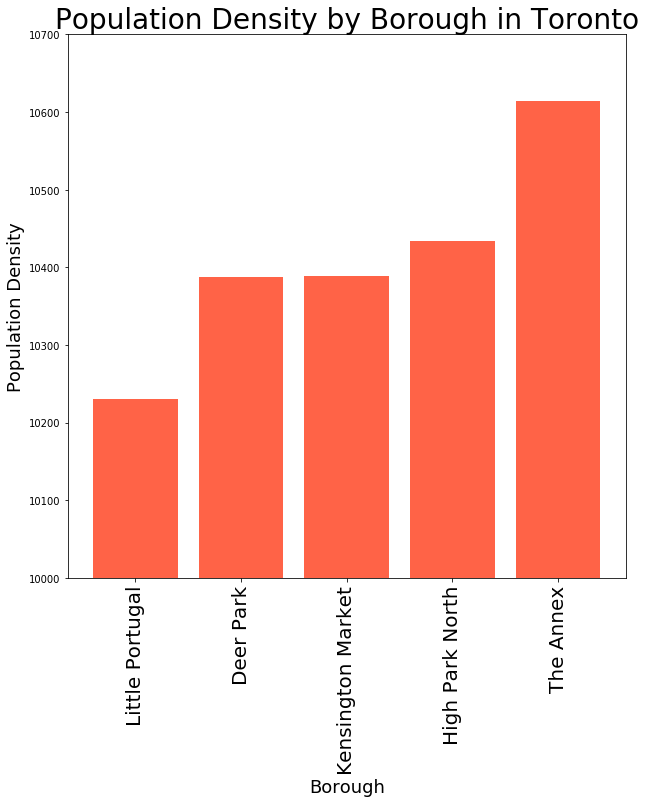

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.bar(popu_toronto['Name'], popu_toronto['Density (people/km2)'], color = 'tomato')
plt.title("Population Density by Borough in Toronto", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Population Density', fontsize = '18')
plt.xticks(fontsize='20', rotation ='90')
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((10000, 10700)) 
plt.show()

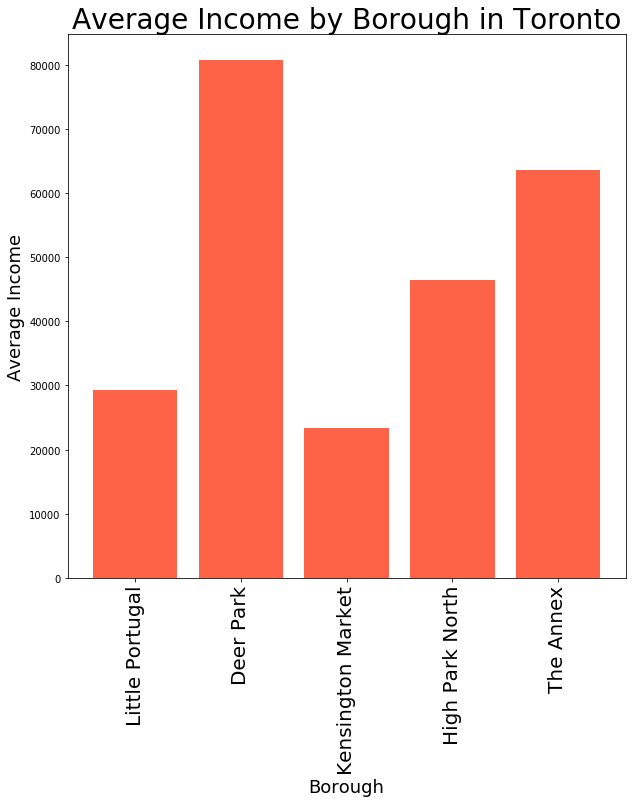

In [47]:
plt.figure(figsize = (10,10))
plt.bar(popu_toronto['Name'], popu_toronto['Average Income'], color = 'tomato')
plt.title("Average Income by Borough in Toronto", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Average Income', fontsize = '18')
plt.xticks(fontsize='20', rotation ='90')
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((bottom, top)) 
plt.show()

#### 3.2 New York city

In [2]:
import requests
from bs4 import BeautifulSoup
import csv
r = requests.get('https://en.wikipedia.org/wiki/Boroughs_of_New_York_City')
soup = BeautifulSoup(r.text,'html.parser')
table = soup.find('table',attrs = {'class':'wikitable sortable'})

In [3]:
headers = [header.text for header in table.find_all('th')]

In [4]:
table_rows = table.find_all('tr')        
rows = []
for row in table_rows:
   td = row.find_all('td')
   row = [row.text for row in td]
   rows.append(row)

with open('newyork_population.csv', 'w') as f:
   writer = csv.writer(f)
   writer.writerow(headers)
   writer.writerows(row for row in rows if row)

In [50]:
import pandas as pd
popu_newyork = pd.read_csv('newyork_population.csv',header = 0)

print('Data downloaded!')
popu_newyork.drop(popu_newyork.columns[6:15], axis = 1,inplace = True)
cols = [1,4]
popu_newyork.drop(popu_newyork.columns[cols], axis = 1, inplace = True)
popu_newyork.rename(columns={ popu_newyork.columns[0]: "Borough" }, inplace = True)
popu_newyork.rename(columns={ popu_newyork.columns[3]: "Density" }, inplace = True)
popu_newyork.rename(columns={ popu_newyork.columns[1]: "Population" }, inplace = True)
popu_newyork.rename(columns={ popu_newyork.columns[2]: "Gross Domestic Product" }, inplace = True)
popu_newyork.columns


Data downloaded!


Index(['Borough', 'Population', 'Gross Domestic Product', 'Density'], dtype='object')

In [51]:
popu_newyork = popu_newyork.head(5)
popu_newyork = popu_newyork.replace('\n','', regex=True)
popu_newyork = popu_newyork.replace(',','', regex=True)
popu_newyork[['Population','Density','Gross Domestic Product']] = popu_newyork[['Population','Density','Gross Domestic Product']].apply(pd.to_numeric)

In [52]:
popu_newyork.dtypes

Borough                    object
Population                  int64
Gross Domestic Product    float64
Density                   float64
dtype: object

In [36]:
popu_newyork

,Borough,Population,Gross Domestic Product,Density
0,The Bronx,1418207,42.695,42.10
1,Brooklyn,2559903,91.559,70.82
2,Manhattan,1628706,600.244,22.83
3,Queens,2253858,93.310,108.53
4,Staten Island,476143,14.514,58.37


In [37]:
popu_newyork['Density'] = popu_newyork['Density'].map(lambda x: x*1000)  
popu_newyork

,Borough,Population,Gross Domestic Product,Density
0,The Bronx,1418207,42.695,42100.0
1,Brooklyn,2559903,91.559,70820.0
2,Manhattan,1628706,600.244,22830.0
3,Queens,2253858,93.310,108530.0
4,Staten Island,476143,14.514,58370.0


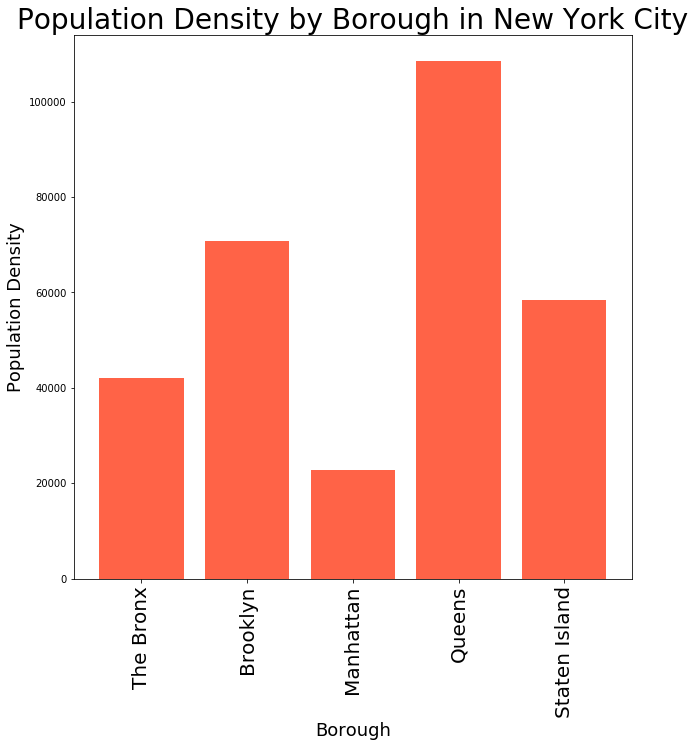

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.bar(popu_newyork['Borough'], popu_newyork['Density'], color = 'tomato')
plt.title("Population Density by Borough in New York City", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Population Density', fontsize = '18')
plt.xticks(fontsize='20', rotation ='90')
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((bottom, top)) 
plt.show()

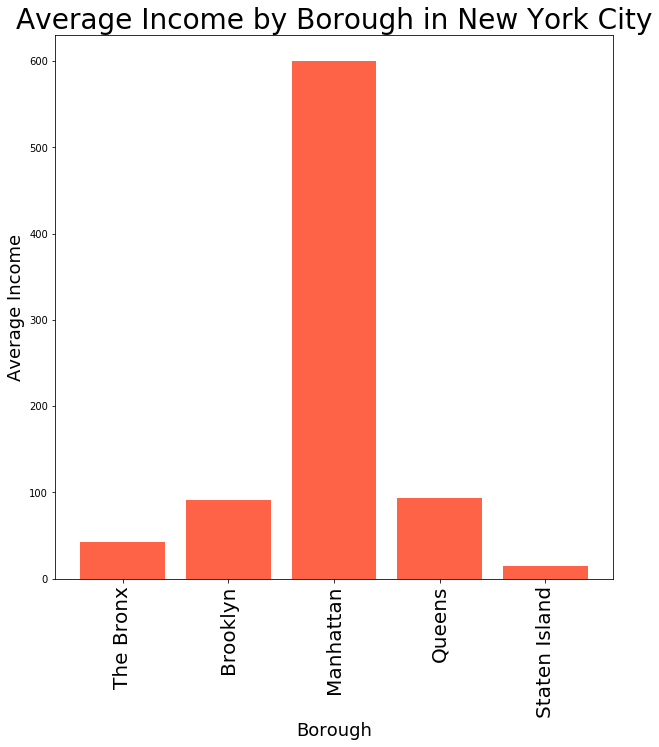

In [53]:
plt.figure(figsize = (10,10))
plt.bar(popu_newyork['Borough'], popu_newyork['Gross Domestic Product'], color = 'tomato')
plt.title("Average Income by Borough in New York City", fontsize = '28')
plt.xlabel('Borough', fontsize = '18')
plt.ylabel('Average Income', fontsize = '18')
plt.xticks(fontsize='20', rotation ='90')
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((bottom, top)) 
plt.show()